# Housekeeping (execute once per kernel restart)

In [ ]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

In [ ]:
!pip install --user --upgrade pip
!pip install --user --upgrade tqdm watermark
!pip install --user --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#!pip install "jax[cpu]===0.3.14" -f https://whls.blob.core.windows.net/unstable/index.html --use-deprecated legacy-resolver

In [1]:
# change directory to parent for local imports
import os
os.chdir('..')
print(os.getcwd())

/nfs/git/InteractiveInference/src/hello_world


In [3]:
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
import importlib

import minimal_agent_jax as jax_agents
import mountain_car_environment as envs
importlib.reload(envs)

%load_ext watermark
%watermark -n -u -v -iv -w


Last updated: Fri Mar 31 2023

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.11.0

matplotlib: 3.7.1
numpy     : 1.23.5

Watermark: 2.3.1



# Discrete Mountain Car Environment

## Compute discrete transition dynamics

**Note** Uncomment the code in the cell below if it throws an error.

The stochastic discrete dynamics are estimated by Monte Carlo sampling the deterministic continuous dynamics, where stochasticity arises as a result of discretization. Actions performed at different continuous-valued starting states within each discrete state bin result in different continuous-valued successor states, which may fall into several different discrete successor state bins. Normalizing the sample of successor states yields a conditional probability distribution for each state-action pair.

In [4]:
τ = envs.MountainCarDiscrete.load_transition_dynamics()
#τ = envs.MountainCarDiscrete.transition_dynamics(n_samples=50_000)
#envs.MountainCarDiscrete.save_transition_dynamics(τ)

Loading transition dynamics from file "mountain_car_transition_dynamics.npy"


## Explore transition dynamics

In [ ]:
env = envs.MountainCarDiscrete()
env.render_env()

Loading transition dynamics from file "mountain_car_transition_dynamics.npy"


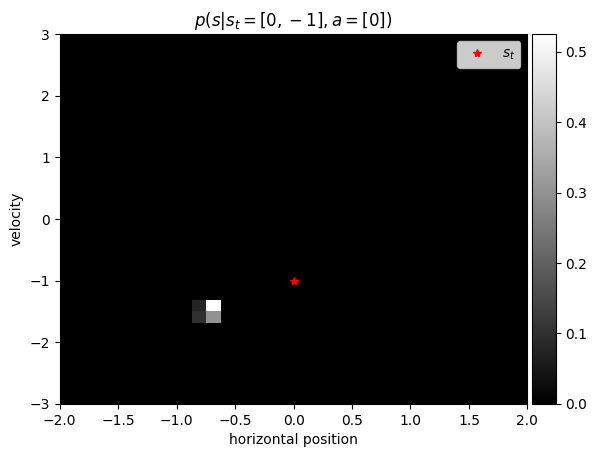

In [6]:
a_i = [0]
s0 = np.array([0, -1])
s0_i = env.index_s_from_s(s0)

plt.title(f"$p(s|s_t={s0.tolist()}, a={a_i})$");
plt.xlabel('horizontal position')
plt.ylabel('velocity')
plt.plot([s0[0]], [s0[1]], 'r*', label='$s_t$', zorder=1)
plt.legend()
env.show_p_s(env.p_s1_given_s_a[s0_i, a_i, :])



## Rollout deterministic continuous dynamics

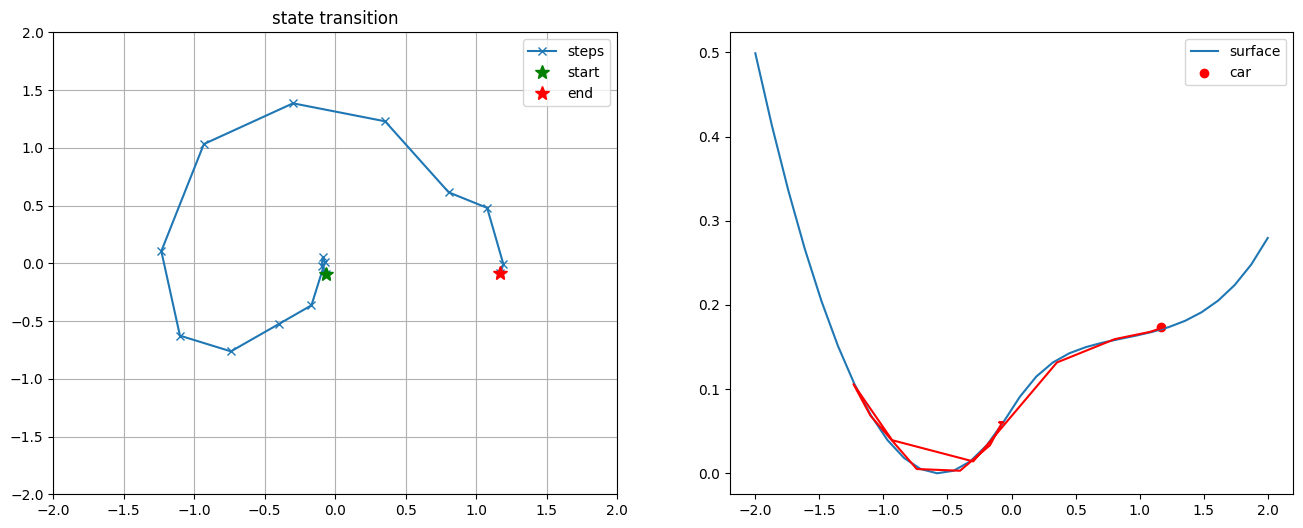

In [8]:
# example tranjectories (in continuous dynamics) from the paper
s0 = [-0.06451613, -0.09677419]
aa_fig4 = [4, 4, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 1, 2] 
        #, 4, 4, 3, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 1, 2]
aa_fig5 = [2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1] #[2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1]

aa = aa_fig4
a = [-2, -1, 0, 1, 2]
aa = [a[x] for x in aa]

ss = [s0]
ss_full = [s0]
for a in aa:
  sol = env.forward_ode(s=ss[-1], a=a, debug=True)
  ss.append(sol.y[:,-1])
  ss_full.extend(sol.y.T.tolist())

fig, ax = plt.subplots(1, 2, figsize=(2*8, 6))
#env.plot_trajectory(ss_full, ax, label='full')
env.plot_trajectory_continuous(ss, ax, label='steps')

## Rollout stochastic discrete dynamics

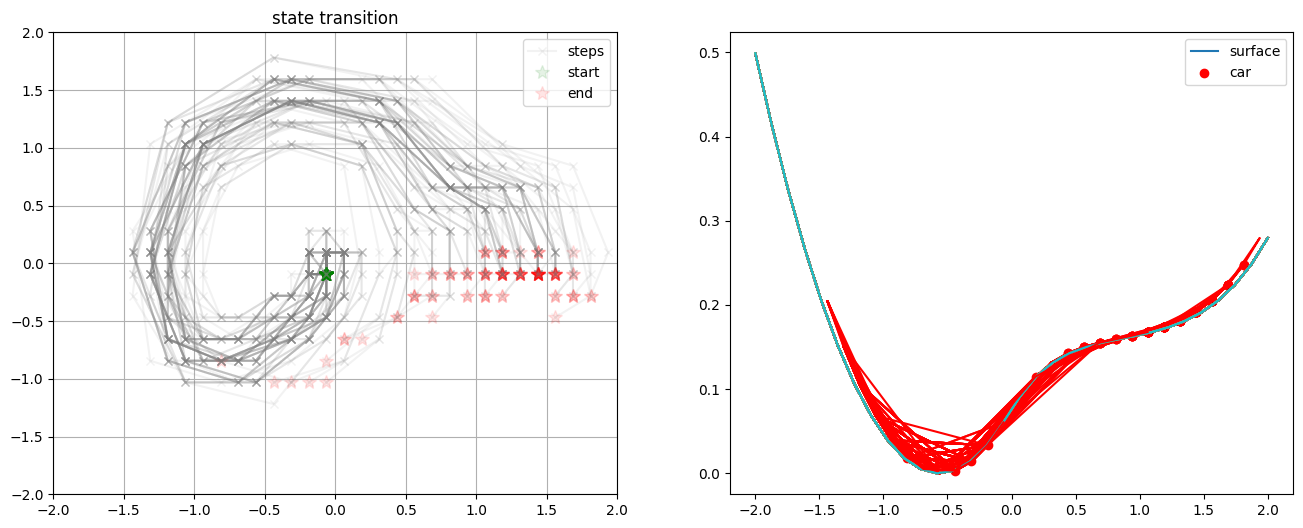

In [9]:
def rollout_plan(env, plan):
    ss = [env.reset()]
    for a in plan:
        s = env.step(a)
        ss.append(np.copy(s))
        
    return ss

# random agent
def rollout_random(env, T):
    plan = np.random.choice(env.a_N, size=T)
    return rollout_plan(env, plan)
    
T = 16
fig, ax = plt.subplots(1, 2, figsize=(2*8, 6))
for i in range(100):
    env.plot_trajectory(rollout_plan(env, aa_fig4), ax=ax, color='gray', alpha=0.1, label='steps', legend=False if i>0 else True)
    #env.plot_trajectory(rollout_random(env, T), ax, label='steps')
    
plt.show()

# Jax agent for fully observed environments

Here, we want to apply the Jax active inference agent to navigate through the state space. Since the state is fully observed, we can simplify the implementation by removing the information gain component.

In [10]:
# - remove p_o_given_s
# - jax_step_fun:
#    - remove o; belief update from observation
#    - remove state info_gain 

In [168]:
import numpy as np

import jax
import jax.numpy as jnp

jax_key = jax.random.PRNGKey(42)
print(f"JAX devices: {jax.devices()}")
print(f"JAX device type: {jax.devices()[0].device_kind}")

def jax_safelog(x):
  return jnp.log( jnp.maximum(x, 1e-16 ))

def jax_fully_observed_batched_fun(q, πs, p_t, log_p_c):
    """ Deterministic policy selection with pragmatic value in fully-observed environment.
    Args:
        num_actions (int): number of unique actions. Jit assumes this is static across calls.
        q (jnp.ndarray): one-hot encoding of the observed state
        πs (jnp.ndarray): 4D tensor of one-hot actions [batch, policy, timestep, one_hot_action].
        p_t (jnp.ndarray): 3D tensor of transition dynamics [a, s0, s1].
        log_p_c (jnp.ndarray): 1D tensor of normalized state preferences. One element per environment state.
    """
    # policy rollout: 
    # one-hot action encoding ensures coalesced access to transition dynamics, 
    # speeding up vectorised rollouts across policies
    def step(q, a):
        q = a @ (q @ p_t)
        return q, q
    
    qs_π = lambda q, π: jax.lax.scan(step, init=q, xs=π)[1] # carry, output
    qs_batch = jax.vmap(qs_π, in_axes=(None, 0), out_axes=(0)) # parallel rollout of policy batch
    # batch computation of negative free energy (here, only pragmatic value)
    def nefe_batch(q, πs):
        pragmatic = (qs_batch(q, πs) @ log_p_c).sum(axis=-1)
        return q, pragmatic
    
    nefe = jax.lax.scan(nefe_batch, init=q, xs=πs)[1] # scan over batches
    π = πs.reshape( (-1,) + πs.shape[2:] )[jnp.argmax(nefe)] # perform policy selection by squeezing first two dimensions
    π = jnp.argmax(π, axis=-1)
    return π

jit_fully_observed_batched_fun = jax.jit(jax_fully_observed_batched_fun)

JAX devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
JAX device type: NVIDIA RTX A6000


In [179]:
class FullyObservedAgentJax:
    """ Minimal agent performing exact inference in fully discrete POMDPs"""
    def __init__(self, 
                 env,
                 target_state, 
                 k=2, 
                 num_batches=1):
        self.env = env
        self.target_state = target_state
        self.k = k
        self.num_batches = num_batches
        
        self.p_t = jnp.asarray(env.p_s1_given_s_a.swapaxes(0,1))
        print(f'Enumerating {self.env.a_N**k:,} candidate policies of length {k}')
        #batched policies
        πs = np.stack(np.meshgrid(*[np.arange(self.env.a_N) for _ in range(k)])).T.reshape(self.num_batches, -1, k)
        # one-hot encoded actions
        self.πs = jax.nn.one_hot(jax.device_put(πs), self.env.a_N, dtype=int)
        
    def reset(self):
        # initialize state preference
        q_star = np.eye(self.env.s_N)[self.target_state] \
                 + 1/(self.env.s_N*5) * np.ones(self.env.s_N)
        q_star = q_star / q_star.sum()
        self.log_p_c = jnp.log( q_star )
        # initialize state prior as uniform
    
    def step(self, o):
        params = {
            'q': jax.nn.one_hot(o, self.env.s_N),
            'p_t': self.p_t,
            'log_p_c': self.log_p_c,
            'πs': self.πs, 
        }
        return jit_fully_observed_batched_fun(**params)

In [188]:
importlib.reload(jax_agents)

k = 10 # planning time horizon
# specify target state as continuous [position, velocity]
targets = {
    4: [-1.0, -0.5],
    6: [-0.2, 1.3],
    8: [1., 0.],
    9: [1., 0.],
    10: [1., 0.],
}
s_target = np.array(targets[k]) 
env = envs.MountainCarDiscrete()
agent = jax_agents.FullyObservedAgentJax(env=env, 
                        target_state=env.index_s_from_s(s_target), 
                        k=k, 
                        num_batches=5**3)
agent.reset()

# plan once at t=0, then execute plan - measure latency
for _ in tqdm([0]):
    aa = np.copy(agent.step(o=env.reset()))
    
print(f"plan: {aa}")

JAX devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
JAX device type: NVIDIA RTX A6000
Fri Mar 31 09:41:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:21:00.0 Off |                  Off |
| 30%   44C    P2    22W / 300W |  37260MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

100%|██████████| 1/1 [00:22<00:00, 22.20s/it]

plan: [0 2 4 4 4 4 1 0 2 2]


In [196]:
n_rollouts = 1

fig, ax = plt.subplots(1,2 , figsize=(2*8, 6))
ax[0].scatter([s_target[0]], [s_target[1]], color='r', marker='o', s=10**2, label='target', zorder=1)
for r in range(n_rollouts):
    ss = [env.reset()]
    for a in aa:
        ss.append(env.step(a))

    env.plot_trajectory(ss, ax=ax, color='gray', legend=False if r>0 else True)

In [145]:
aa

array([0, 2, 4, 4, 4, 4, 1, 0, 2], dtype=int32)

In [113]:
params = {
    'q': jax.nn.one_hot(env.reset(), env.s_N),
    'p_t': agent.p_t,
    'log_p_c': agent.log_p_c,
    'πs': agent.πs.reshape(5**3,-1,agent.k),
    'num_actions': env.a_N
}

jit_fully_observed_batched_fun(**params)

Array([0, 2, 4, 4, 4, 4, 1, 0], dtype=int32)

In [105]:
num_old = (8*390625)/55.52 # naive jax implementation required 55.52 seconds for 390k policies of 8 steps
num_new = (10*9765625)/21.8 # new jax implementation requires 28.52 seconds for 9765k policies of 10 steps
print(f'From {int(num_old):,} to {int(num_new):,} steps per second: {int(num_new/num_old)} x speedup')

From 56,286 to 4,479,644 steps per second: 79 x speedup


In [169]:
# explore gradient descent on probability (belief) over future actions
# - SUCCESS explore actione expansion to one-hot with subsequent full matrix multiply in current jax kernel [t, num_a]
# - initialise vector over actions as logits [t, num_a]
# - perform gradient descent on 
